# 전류 파형 예측 모델 학습 (DNN)

**목표**: Injection Duration (ET)로부터 실제 전류 파형을 예측하는 모델 학습

- **Input**: ET (us) - 1개 스칼라 값
- **Output**: Current Waveform (1300 points) - 시계열 시퀀스
- **Model**: Deep Neural Network (2-3 layers)


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib


In [72]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [73]:
# ---------------------------------------------------------
# 1. 데이터 로드
# ---------------------------------------------------------
print("[1] 데이터 로딩...")
data = np.load('current_waveform_dataset.npz')
X_meta_raw = data['X_meta']  # (N, 1) -> [ET]
y_current = data['y_current']  # (N, 1300) -> Current Waveform

# ET만 추출
if X_meta_raw.shape[1] == 2:
    # (N, 2) 형태인 경우 ET만 추출 (두 번째 컬럼이 ET)
    X_meta = X_meta_raw[:, 1:2]  # (N, 1)
elif X_meta_raw.shape[1] == 1:
    # 이미 ET만 있는 경우
    X_meta = X_meta_raw  # (N, 1)
else:
    raise ValueError(f"Unexpected X_meta shape: {X_meta_raw.shape}")

print(f"Input Shape (X_meta): {X_meta.shape}")
print(f"Output Shape (y_current): {y_current.shape}")
print(f"ET 범위: {X_meta[:, 0].min()} ~ {X_meta[:, 0].max()} us")


[1] 데이터 로딩...
Input Shape (X_meta): (54, 1)
Output Shape (y_current): (54, 1300)
ET 범위: 250 ~ 5000 us


In [74]:
# ---------------------------------------------------------
# 2. 데이터 전처리
# ---------------------------------------------------------
# Train/Test 분리
X_train_meta, X_test_meta, y_train_current, y_test_current = train_test_split(
    X_meta, y_current, test_size=0.2, random_state=42
)

print(f"Train samples: {len(X_train_meta)}")
print(f"Test samples: {len(X_test_meta)}")

# Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_meta)  # (N, 1) - ET only
X_test_scaled = scaler_X.transform(X_test_meta)

scaler_y = MinMaxScaler()
y_train_flat = y_train_current.reshape(-1, 1)
scaler_y.fit(y_train_flat)
y_train_scaled = scaler_y.transform(y_train_flat).reshape(y_train_current.shape)
y_test_flat = y_test_current.reshape(-1, 1)
y_test_scaled = scaler_y.transform(y_test_flat).reshape(y_test_current.shape)

# PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# DataLoader
BATCH_SIZE = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Train samples: 43
Test samples: 11


In [75]:
# ---------------------------------------------------------
# 3. 모델 정의: ET -> Current Waveform (DNN)
# ---------------------------------------------------------
class CurrentWaveformPredictor(nn.Module):
    """
    Input: ET - 1개 스칼라
    Output: Current Waveform - 1300 포인트 시퀀스
    Architecture: Deep Neural Network (4 layers)
    """
    def __init__(self, input_size=1, hidden_size1=256, hidden_size2=512, hidden_size3=512, output_seq_len=1300, num_layers=4):
        super(CurrentWaveformPredictor, self).__init__()
        
        self.output_seq_len = output_seq_len
        
        # Input layer: ET (1) -> hidden_size1
        self.fc1 = nn.Linear(input_size, hidden_size1)
        
        if num_layers == 4:
            # Hidden layer 1: hidden_size1 -> hidden_size2
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            # Hidden layer 2: hidden_size2 -> hidden_size2
            self.fc3 = nn.Linear(hidden_size2, hidden_size2)
            # Hidden layer 3: hidden_size2 -> hidden_size3
            self.fc4 = nn.Linear(hidden_size2, hidden_size3)
            # Output layer: hidden_size3 -> 1300
            self.fc_out = nn.Linear(hidden_size3, output_seq_len)
        else:
            # 2 layers: hidden_size1 -> output_seq_len
            self.fc2 = None
            self.fc3 = None
            self.fc4 = None
            self.fc_out = nn.Linear(hidden_size1, output_seq_len)
        
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x: (batch_size, 1) -> [ET]
        # Input layer
        x = torch.relu(self.fc1(x))  # (batch_size, hidden_size1)
        x = self.dropout(x)
        
        if self.num_layers == 4:
            # Hidden layer 1
            x = torch.relu(self.fc2(x))  # (batch_size, hidden_size2)
            x = self.dropout(x)
            # Hidden layer 2
            x = torch.relu(self.fc3(x))  # (batch_size, hidden_size2)
            x = self.dropout(x)
            # Hidden layer 3
            x = torch.relu(self.fc4(x))  # (batch_size, hidden_size3)
            x = self.dropout(x)
        
        # Output layer: directly output 1300 points
        out = self.fc_out(x)  # (batch_size, output_seq_len)
        
        return out  # (batch_size, output_seq_len)

# 모델 초기화 (4 layers)
model = CurrentWaveformPredictor(input_size=1, hidden_size1=256, hidden_size2=512, hidden_size3=512, output_seq_len=1300, num_layers=4).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 1,324,308


In [76]:
# ---------------------------------------------------------
# 3. 모델 정의: ET -> Current Waveform (LSTM)
# ---------------------------------------------------------
class CurrentWaveformPredictor(nn.Module):
    def __init__(self, seq_len=1300, hidden_size=64):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_size = hidden_size

        # 1. ET(Scalar, Duration)을 고차원 특징으로 변환
        self.embedding = nn.Linear(1, hidden_size)

        # 2. 시계열 생성을 위한 LSTM
        # input_size = hidden_size(임베딩) + 1(정규화된 시간)
        self.lstm = nn.LSTM(
            input_size=hidden_size + 1,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.1
        )

        # 3. 최종 출력 (Current Value)
        self.fc = nn.Linear(hidden_size, 1)

        # 4. 활성화 함수 (ReLU)
        self.relu = nn.ReLU()
    
    def forward(self, duration):
        """
        duration: (batch_size, 1) - 정규화된 ET/Duration 입력 [0~1]
        """
        batch_size = duration.size(0)
        device = duration.device

        # A. Duration Embedding
        # (batch, 1) -> (batch, hidden)
        emb = self.relu(self.embedding(duration))

        # B. 임베딩 확장 (sequence length만큼 반복)
        # (batch, hidden) -> (batch, seq_len, hidden)
        emb_seq = emb.unsqueeze(1).expand(-1, self.seq_len, -1)

        # C. 시간 정보(Positional Encoding) 추가
        # (seq_len,) -> (1, seq_len, 1) -> (batch, seq_len, 1)
        time_steps = torch.linspace(0, 1, self.seq_len, device=device)
        time_seq = time_steps.unsqueeze(0).unsqueeze(2).expand(batch_size, self.seq_len, 1)
        
        # 입력 결합: [Duration 임베딩, 정규화된 시간 정보]
        lstm_input = torch.cat([emb_seq, time_seq], dim=2) # (batch, seq_len, hidden+1)

        # D. LSTM 통과
        lstm_out, _ = self.lstm(lstm_input)

        # E. 최종 전류 예측
        current_pred = self.fc(lstm_out) # (batch, seq_len, 1)

        # (batch, seq_len)로 reshape 및 음수값 방지
        current_pred = self.relu(current_pred)
        current_pred = current_pred.squeeze(-1) # (batch, seq_len)

        return current_pred


In [77]:
# ---------------------------------------------------------
# 4. 모델 학습
# ---------------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

NUM_EPOCHS = 1000
train_losses = []
val_losses = []

print(f"\n[2] 모델 학습 시작...")
print(f"{'='*50}")

best_val_loss = float('inf')
patience_counter = 0
patience_limit = 120

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    # Best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'current_waveform_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n{'='*50}")
print(f"학습 완료!")
print(f"최고 Validation Loss: {best_val_loss:.6f}")



[2] 모델 학습 시작...
Epoch [10/1000] - Train Loss: 0.002625, Val Loss: 0.002822


Epoch [20/1000] - Train Loss: 0.001642, Val Loss: 0.001758
Epoch [30/1000] - Train Loss: 0.001504, Val Loss: 0.001485
Epoch [40/1000] - Train Loss: 0.001230, Val Loss: 0.001151
Epoch [50/1000] - Train Loss: 0.000995, Val Loss: 0.000974
Epoch [60/1000] - Train Loss: 0.001050, Val Loss: 0.001007
Epoch [70/1000] - Train Loss: 0.000838, Val Loss: 0.000946
Epoch [80/1000] - Train Loss: 0.000809, Val Loss: 0.000992
Epoch [90/1000] - Train Loss: 0.000786, Val Loss: 0.000857
Epoch [100/1000] - Train Loss: 0.000682, Val Loss: 0.000661
Epoch [110/1000] - Train Loss: 0.000713, Val Loss: 0.000570
Epoch [120/1000] - Train Loss: 0.000651, Val Loss: 0.000591
Epoch [130/1000] - Train Loss: 0.000607, Val Loss: 0.000499
Epoch [140/1000] - Train Loss: 0.000518, Val Loss: 0.000532
Epoch [150/1000] - Train Loss: 0.000507, Val Loss: 0.000534
Epoch [160/1000] - Train Loss: 0.000487, Val Loss: 0.000505
Epoch [170/1000] - Train Loss: 0.000449, Val Loss: 0.000457
Epoch [180/1000] - Train Loss: 0.000516, Val Lo

In [78]:
# ---------------------------------------------------------
# 5. 모델 평가
# ---------------------------------------------------------
# Best model 로드
model.load_state_dict(torch.load('current_waveform_model.pth'))
model.eval()

with torch.no_grad():
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Inverse transform
y_pred_unscaled = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).reshape(y_pred_test.shape)
y_true_unscaled = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).reshape(y_test_current.shape)

# R2 Score
r2 = r2_score(y_true_unscaled.flatten(), y_pred_unscaled.flatten())
rmse = np.sqrt(mean_squared_error(y_true_unscaled.flatten(), y_pred_unscaled.flatten()))
max_current = np.max(y_true_unscaled)
rmse_percent = (rmse / max_current) * 100

print(f"\n[3] 모델 성능 평가")
print(f"{'='*50}")
print(f"R² Score: {r2:.5f}")
print(f"RMSE: {rmse:.4f} A")
print(f"RMSE (Peak 대비): {rmse_percent:.2f}%")
print(f"{'='*50}")



[3] 모델 성능 평가
R² Score: 0.97682
RMSE: 0.2374 A
RMSE (Peak 대비): 2.08%


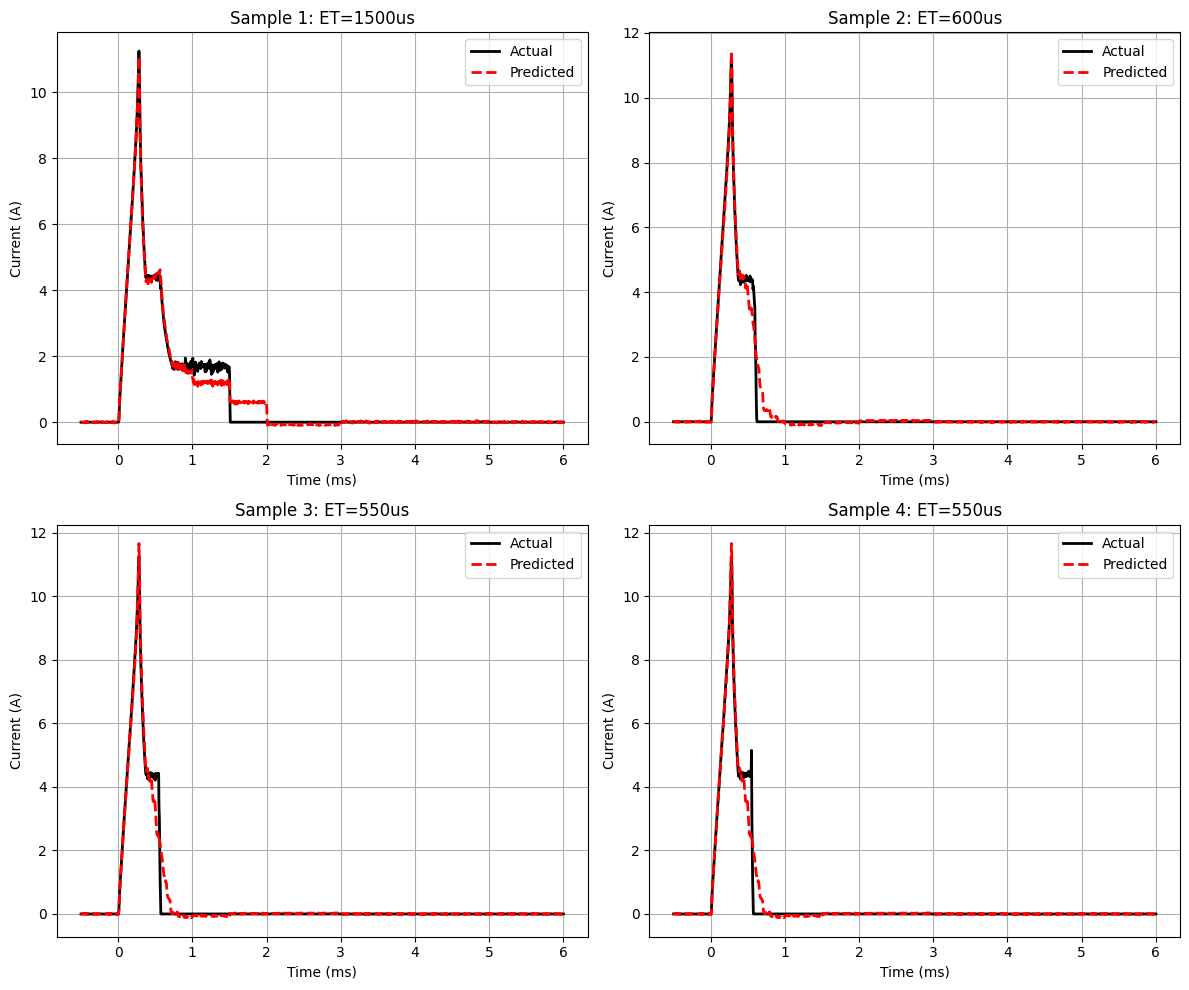

결과 그래프가 'current_waveform_result.png'로 저장되었습니다.


In [79]:
# ---------------------------------------------------------
# 6. 결과 시각화
# ---------------------------------------------------------
time_axis = np.linspace(-0.5, 6.0, 1300)

# 몇 개 샘플 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx in range(min(4, len(y_test_current))):
    ax = axes[idx]
    
    et = X_test_meta[idx, 0]  # ET만 사용
    
    ax.plot(time_axis, y_true_unscaled[idx], 'k-', label='Actual', linewidth=2)
    ax.plot(time_axis, y_pred_unscaled[idx], 'r--', label='Predicted', linewidth=2)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (A)')
    ax.set_title(f'Sample {idx+1}: ET={et:.0f}us')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('current_waveform_result.png', dpi=150)
plt.show()

print("결과 그래프가 'current_waveform_result.png'로 저장되었습니다.")


In [80]:
# ---------------------------------------------------------
# 7. Scaler 저장 (앱에서 사용하기 위해)
# ---------------------------------------------------------
joblib.dump(scaler_X, 'current_scaler_X.pkl')
joblib.dump(scaler_y, 'current_scaler_y.pkl')

print("\n[4] Scaler 저장 완료!")
print("   - current_scaler_X.pkl (Input: ET)")
print("   - current_scaler_y.pkl (Output: Current Waveform)")
print("\n✅ 모든 작업이 완료되었습니다!")
print("   - 모델: current_waveform_model.pth")
print("   - 결과 그래프: current_waveform_result.png")



[4] Scaler 저장 완료!
   - current_scaler_X.pkl (Input: ET)
   - current_scaler_y.pkl (Output: Current Waveform)

✅ 모든 작업이 완료되었습니다!
   - 모델: current_waveform_model.pth
   - 결과 그래프: current_waveform_result.png
